# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import glob
import cv2
# from google.colab.patches import cv2_imshow
import pandas as pd
import random
import numpy
import matplotlib.pyplot as plt
# from enhance import image_enhance
from skimage.morphology import skeletonize, thin
import torchvision.transforms as transforms
import torch
from PIL import Image
import PIL

In [2]:
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [43]:
base_model_path = Path(r"G:\.shortcut-targets-by-id\1PZATv1p2aSMOQHDbAM3H0KTjWltMu5YF\Pretrained Models\SPD2010")
YOLO_model_path = base_model_path/'YOLO'
DDQN_model_path = base_model_path/'DDQN'
settings = {
              "syn": {
                  "file_type":"tiff",
                  "li":2,
                  "ui":5,
                  "yolo_model":'/content/drive/MyDrive/rotated_data_1000_100.pth',
                  "ddqn_q_eval": "/content/drive/MyDrive/dqn_q_eval_10011.pth",
                  "ddqn_q_next": "/content/drive/MyDrive/dqn_q_next_10011.pth"
               },
              "spd": {
                  "file_type":"bmp",
                  "li":0,
                  "ui": 4,
                  "yolo_model": YOLO_model_path/"spd_500_200.pth",
                  "ddqn_q_eval": DDQN_model_path/"dqn_q_eval_100spd11.pth",
                  "ddqn_q_next": DDQN_model_path/"dqn_q_next_100spd11.pth"
                },
              "fvc": {
                  "file_type": "tif",
                  "li": 0,
                  "ui": 3,
                  "yolo_model":'/content/drive/MyDrive/spd_500_200.pth',
                  "ddqn_q_eval": "/content/drive/MyDrive/dqn_q_eval_100spd11.pth",
                  "ddqn_q_next": "/content/drive/MyDrive/dqn_q_next_100spd11.pth"
                }
            }
db_set = "spd"         # Change the type of database here
                       # Synthetic : 'syn'
                       # SPD2010 : 'spd'
                       # FVC2002B : 'fvc'

# YOLO related functions

In [4]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [5]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [6]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 7 * 7, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

##Intersection over Union

In [7]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # print("IOU:",intersection / (box1_area + box2_area - intersection + 1e-6))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

##NMS Function

In [8]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [9]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

##Transforms

In [10]:
class testCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)

        return img

In [11]:
transform_test = testCompose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [12]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
model = model.to(device)

#Replay Buffer

In [13]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

#Q_Network

In [14]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_size, output_size):
    super(DeepQNetwork, self).__init__()
    self.dense1 = nn.Linear(input_size, 128)
    self.dense2 = nn.Linear(128, 64)
    self.dense3 = nn.Linear(64, output_size)
    self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, x):
    x = F.relu(self.dense1(x))
    x = F.relu(self.dense2(x))
    x = self.dense3(x)
    return x

#Agent

In [15]:
class DDQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,replace=1000):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        # self.env_name = env_name
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr,self.input_dims,self.n_actions)
        self.q_next = DeepQNetwork(self.lr, self.input_dims,self.n_actions)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation,dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def replace_target_network(self):
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()

        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_)
        q_eval = self.q_eval.forward(states_)

        max_actions = T.argmax(q_eval, dim=1)
        q_next[dones] = 0.0

        q_target = rewards + self.gamma*q_next[indices, max_actions]
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()

        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

    def save_models(self,path,name):
        torch.save({
            'model_state_dict': self.q_eval.state_dict()
        }, os.path.join(path,'dqn_q_eval_'+name+'.pth'))
        torch.save({
            'model_state_dict': self.q_next.state_dict()
        }, os.path.join(path,'dqn_q_next_'+name+'.pth'))
        # self.q_eval.save_checkpoint()
        # self.q_next.save_checkpoint()

    def load_models(self,file_path_eval,file_path_next):
        checkpoint = torch.load(file_path_eval, map_location=device)
        self.q_eval.load_state_dict(checkpoint['model_state_dict'])
        checkpoint = torch.load(file_path_next, map_location=device)
        self.q_next.load_state_dict(checkpoint['model_state_dict'])
        # self.q_eval.load_checkpoint()
        # self.q_next.load_checkpoint()

### Functions related to Fingerprint Recognition

In [16]:
def get_descriptors(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # img = image_enhance.image_enhance(img)
    # img = fingerprint_enhancer.enhance_Fingerprint(img)
    img = numpy.array(img, dtype=numpy.uint8)
    # Threshold
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Normalize to 0 and 1 range
    img[img == 255] = 1
    # skeleton = cv2.ximgproc.thinning(img, thinningType = cv2.ximgproc.THINNING_GUOHALL)
    #Thinning
    # skeleton = skeletonize(img)
    # skeleton = numpy.array(skeleton, dtype=numpy.uint8)
    # skeleton = self.removedot(skeleton)
    # Harris corners
    harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
    harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    threshold_harris = 125
    # Extract keypoints
    keypoints = []
    for x in range(0, harris_normalized.shape[0]):
      for y in range(0, harris_normalized.shape[1]):
        if harris_normalized[x][y] > threshold_harris:
          keypoints.append(cv2.KeyPoint(y, x, 1))
    # Define descriptor
    orb = cv2.ORB_create()
    # Compute descriptors
    _, des = orb.compute(img, keypoints)
    return (keypoints, des);
def isMatching(img1,img2):

    # img1 = cv2.imread("test_fprs/" + image_name1, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = get_descriptors(img1)

    # img2 = cv2.imread("database/" + image_name2, cv2.IMREAD_GRAYSCALE)
    kp2, des2 = get_descriptors(img2)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)

    score = 0
    for match in matches:
      score += match.distance

    score_threshold = 33
    return score/(len(matches)+1)

def isMatching_des(d1,d2):
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = sorted(bf.match(d1, d2), key= lambda match:match.distance)

  score = 0
  for match in matches:
    score += match.distance

  score_threshold = 33
  return score/(len(matches)+1)

## Environment

In [50]:
class Environment:
  # list[x,y,width1,width2,height1,height2]
  def __init__(self,image,state,data,id,pixel_size):
    self.w1 = state[2]#width1
    self.w2 = state[3] #width2
    self.h1 = state[4] # height1
    self.h2 = state[5] #height2
    self.pixel = pixel_size
    self.image=image
    self.data = data
    self.id =id
    self.x = state[0] #x
    self.y = state[1]
    self.total_rows = self.image.shape[0]
    self.total_columns = self.image.shape[1]
    self.action_count = 10

  def step(self,action):
     # list[x,y,width1,width2,height1,height2]
    flag = self.act(action)
    reward = 0
    if  flag:
      value,done = self.get_reward()
      reward = value
    else:
      reward = 0
      if  self.action_count:
        done = 0
        self.action_count -= 1
      else:
        done = 1

    next_state = [self.x,self.y,self.w1,self.w2,self.h1,self.h2]
    return next_state,reward,done

  def act(self,action):
    flag = 1
    if action == 0:
      #Increase width1
      change = self.w1 + self.pixel
      if self.y-change <= 0 :
        flag = 0
      else:
        self.w1 = self.w1 + self.pixel

    if action == 1:
      #Decrease width1
      change = self.w1-self.pixel
      if self.y-change >= self.y:
        flag = 0
      else:
        self.w1 = self.w1 - self.pixel

    if action == 2:
      #increase width2
      change = self.w2 + self.pixel
      if self.y+change >= self.total_columns:
        flag = 0
      else:
        self.w2 = self.w2 + self.pixel

    if action == 3:
      #Decrease width2
      change = self.w2 - self.pixel
      if self.y +change <= self.y:
        flag = 0
      else:
        self.w2 = self.w2 - self.pixel

    if action == 4:
      #increase height1
      change = self.h1 + self.pixel
      if self.x-change <= 0:
        flag = 0
      else:
        self.h1 = self.h1 + self.pixel

    if action == 5:
      #Decrease height1
      change = self.h1 - self.pixel
      if self.x-change >=self.x:
        flag = 0
      else:
          self.h1 = self.h1 - self.pixel

    if action == 6:
      #increase height2
      change = self.h2 + self.pixel
      if self.x+change >= self.total_rows:
        flag = 0
      else:
        self.h2 = self.h2 + self.pixel

    if action == 7:
      #Decrease height2
      change = self.h2 - self.pixel
      if self.x+change <= self.x:
        flag = 0
      else:
        self.h2 = self.h2 - self.pixel
    # print("Returning flag",flag)
    return flag


  def compare_all(self,image):
    scores = []
    k, d = get_descriptors(image)
    for i in descs:
      scores.append(isMatching_des(d,i))
    if scores.count(0) == len(scores):
      # print("all zeroes")
      borderPassed=0
      return -1,0
    else:
      value = min(scores)
      print(scores)
      max_index = scores.index(value)
      value = 100-value
      # print(self.data.iloc[max_index]['id'], value)
      return value,max_index

  def get_reward(self):
    crop_image = self.image[self.x-self.h1:self.x+self.h2,self.y-self.w1:self.y+self.w2]
    value,max_index = self.compare_all(crop_image)
    if value != -1:
      li = settings[db_set]["li"]
      ui = settings[db_set]["ui"]
      if self.data.iloc[max_index]['id'][li:ui] == self.id[li:ui]: ## Change this when changing the dataset based on how the impressions are labelled
        return value,1
      elif self.data.iloc[max_index]['id'][li:ui] != self.id[li:ui]: ## Change this when changing the dataset based on how the impressions are labelled
        return -1*(value-30),0
    else:
      return -50,0


In [18]:
## randomly selects a fingerprint image from database, extracts yolo bbox using loaded yolo model
## returns the state of the environment as (x,y,w1,w2,h1,h2) for that image
def set_env():
  index = random.randint(0,data.shape[0]-1)
  id = data.iloc[index]['id']
  print("------------------ ",id," -------------------")
  image = cv2.imread(str(data.iloc[index]['path']),0)
  nms_boxes = get_img_result(str(data.iloc[index]['path']))
  if len(nms_boxes)==0:
    x = image.shape[0]//2
    y = image.shape[1]//2
    width1 = y//4
    width2= y//4
    height1= x//4
    height2= x//4
    state = [x,y,width1,width2,height1,height2]
    return image,state,id
  width = image.shape[1]
  height = image.shape[0]
  bbox = nms_boxes[0][2:]
  print(bbox)
  state = [bbox[1]*height, bbox[0]*width, (bbox[2]*width)/2, (bbox[2]*width)/2, (bbox[3]*height)/2,(bbox[3]*height)/2]
  state = [int(i) for i in state]
  # state = [x,y,width1,width2,height1,height2]
  return image,state,id

# Utils

In [19]:
batch_size = 64         # minibatch size
gamma = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
state_size = 6
action_size= 8
epsilon=1.0
eps_min=0.01
replace=50
eps_dec=1e-4
mem_size = 1000000

In [36]:
agent = DDQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
                  input_dims=state_size,
                  n_actions=action_size, mem_size=50000, eps_min=0.1,
                  batch_size=64, replace=100, eps_dec=5e-5)

<ipython-input-13-b0ccf1341747>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


In [20]:
def clean_data(base_path):         # Converts all images into '.jpg'
  for img in os.listdir(base_path):
    read = cv2.imread(base_path + img)
    outfile = img.split('.')[0] + '.jpg'
    cv2.imwrite(base_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 200])

In [21]:
def getdata_dataframe(datapath):
    persons = []
    image_paths = []
    images = Path(datapath).glob('*.'+settings[db_set]["file_type"]) ## Change this when changing the dataset based on the extension of the images
    for image in images:
      img = str(image)
      person_id = img.split('/')[-1].split('.')[0]
      persons.append(person_id)
      image_paths.append(img)
    return persons,image_paths

In [22]:
## returns final bboxes after passing an image to pretrained yolo model
def get_img_result(img_path,yolo_model):
  img_path = img_path.split(".")[0]+".jpg"
  test_image = Image.open(img_path)
  test_image_tensor = transform_test(test_image)

  output = yolo_model(test_image_tensor.unsqueeze(0).to(device))
  output = output.reshape(-1,7,7,30)
  boxes = cellboxes_to_boxes(output, S=7)
  boxes = torch.tensor(boxes).squeeze(0)
  boxes = boxes.tolist()
  nms_boxes = non_max_suppression(boxes, 0.5, 0.4)
  return nms_boxes


In [23]:
## randomly selects a fingerprint image from database, extracts yolo bbox using loaded yolo model
## returns the state of the environment as (x,y,w1,w2,h1,h2) for that image
def set_env(yolo_model):
  index = random.randint(0,data.shape[0]-1)
  id = data.iloc[index]['id']
  print("------------------ ",id," -------------------")
  image = cv2.imread(str(data.iloc[index]['path']),0)
  nms_boxes = get_img_result(str(data.iloc[index]['path']),yolo_model)
  if len(nms_boxes)==0:
    x = image.shape[0]//2
    y = image.shape[1]//2
    width1 = y//4
    width2= y//4
    height1= x//4
    height2= x//4
    state = [x,y,width1,width2,height1,height2]
    return image,state,id
  width = image.shape[1]
  height = image.shape[0]
  bbox = nms_boxes[0][2:]
  print(bbox)
  state = [bbox[1]*height, bbox[0]*width, (bbox[2]*width)/2, (bbox[2]*width)/2, (bbox[3]*height)/2,(bbox[3]*height)/2]
  state = [int(i) for i in state]
  # state = [x,y,width1,width2,height1,height2]
  return image,state,id

In [24]:
## shows cropped image based on state
def show_crop_image(image,state):
  # print(state[0]-state[2],state[0]+state[3],state[1]-state[4],state[1]-state[5])
  crop_image = image[state[0]-state[4]:state[0]+state[5],state[1]-state[2]:state[1]+state[3]]
  gray = cv2.cvtColor(crop_image, cv2.COLOR_GRAY2RGB)
  plt.imshow(gray)
  plt.axis('off')
  plt.show()

In [25]:
import matplotlib.patches as patches
## prints bbox on fingerprint image when state is given
def show_img_bbox(image,state):
    f, axarr = plt.subplots()
    cv2_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(cv2_img)
    # image = Image.open("database/"+id+".jpg")
    width, height = image.size
    # image = transform_test(image)
    # im = np.array(image)
    # im = np.transpose(im, (1, 2, 0))
    # height, width, _ = im.shape
    axarr.imshow(image)
    upper_left_x = state[0]-state[4]
    upper_left_y = state[1]-state[2]
    rect = patches.Rectangle(
        (upper_left_y, upper_left_x),
        state[2]+state[3],
        state[4]+state[5],
        linewidth=2,
        edgecolor="b",
        facecolor="none",
    )
    # Add the patch to the Axes
    axarr.add_patch(rect)
    axarr.axis('off')
    plt.show()

# Main

In [53]:
## Prints all resuts when img path and its id are given
## original image, yolo bbox, yolo-ddqn bbox,
def showROI(db_path,img_name,yolo_model,agent):
  img_path = os.path.join(db_path,img_name)
  test_id = img_name.split(".")[0]
  print("########### "+str(test_id)+" #############")
  image = cv2.imread(img_path,0)

  cv2_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img1 = Image.fromarray(cv2_img)

  plt.imshow(img1)
  plt.axis('off')
  plt.show()
  nms_boxes = get_img_result(img_path,yolo_model)

  width = image.shape[1]
  height = image.shape[0]
  if len(nms_boxes)==0:
    x = image.shape[0]//2
    y = image.shape[1]//2
    width1 = y//4
    width2= y//4
    height1= x//4
    height2= x//4
    state = [x,y,width1,width2,height1,height2]
  else:
    bbox = nms_boxes[0][2:]
    state = [bbox[1]*height, bbox[0]*width, (bbox[2]*width)/2, (bbox[2]*width)/2, (bbox[3]*height)/2,(bbox[3]*height)/2]
    state = [int(i) for i in state]

  print(state)
  yolo_state = list(state)
  # show_img_bbox(image,state)
  # show_bbox_yolo_ddqn(image,state,state,test_id)

  ## Expanding the bbox
  state[2]+=(0.1)*image.shape[1]+10
  state[3]+=(0.1)*image.shape[1]+10
  state[4]+=(0.1)*image.shape[0]+10
  state[5]+=(0.1)*image.shape[0]+10
  state = [int(i) for i in state]

  ## Checking if the bbox crosses img boundaries
  if state[0]-state[4]<=0:
    state[4]=state[0]-5
  if state[0]+state[5]>=height:
    state[5]=height-5-state[0]
  if state[1]-state[2]<=0:
    state[2]=state[1]-5
  if state[1]+state[3]>=width:
    state[3]=width-5-state[1]


  env = Environment(image,state,data,test_id,10)
  count=25
  while True:
    action = agent.choose_action(torch.tensor(state,dtype=torch.float))
    next_state,reward,done = env.step(action) # get reward
    state = next_state
    # print("--------Reward----------   ",reward)
    if reward>90 or done==True:
      break
    count = count-1
    if count == 0:
      break

  crop_image = image[state[0]-state[4]:state[0]+state[5],state[1]-state[2]:state[1]+state[3]]
  show_crop_image(image,state)
  # cv2.imwrite("spd100_ddqn/"+str(test_id)+".jpg", crop_image)
  # show_bbox_yolo_ddqn(image,yolo_state,state,test_id)
  show_img_bbox(image,state)

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
## Change the parameters according to the type of database we are currently working with
yolo_model_path = "/content/drive/MyDrive/checkpoint.pth"
ddqn_q_eval_path = "/content/drive/MyDrive/dqn_q_eval_100_pos1.pth"
ddqn_q_next_path = "/content/drive/MyDrive/dqn_q_next_100_pos1.pth"
database = "database"
# 2 files dqn_q_eval_<model_name>.pth and dqn_q_next_<model_name>.pth will be saved into <ddqn_save_dir> directory

In [34]:
# Load YOLO model
state_dict = torch.load(yolo_model_path,map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [37]:
# Load DDQN agent
agent.load_models(ddqn_q_eval_path,ddqn_q_next_path)

In [32]:
clean_data(database+'/')

data = pd.DataFrame()
persons,image_paths = getdata_dataframe(database)
data['id'] = persons
data['path'] = image_paths

descs = []
for ind in data.index:
  im = cv2.imread(data.iloc[ind]['path'],0)
  k, d = get_descriptors(im)
  descs.append(d)

In [33]:
data.head()

,id,path
0,61035,database/61035.tiff
1,32095,database/32095.tiff
2,45085,database/45085.tiff
3,57053,database/57053.tiff
4,70096,database/70096.tiff


########### 00074 #############


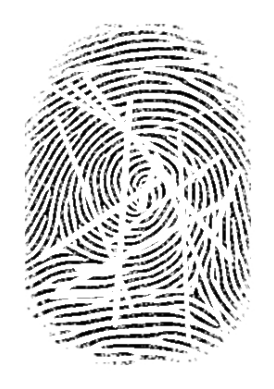

[213, 141, 51, 51, 52, 52]
[27.205882352941178, 26.392857142857142, 23.75, 20.266666666666666, 28.7, 29.0, 26.543478260869566, 33.25, 29.16216216216216, 24.666666666666668, 30.102040816326532, 24.303571428571427, 23.57777777777778, 32.53703703703704, 23.055555555555557, 39.14705882352941, 35.5625, 23.37837837837838, 23.357142857142858, 31.466666666666665, 27.11111111111111, 23.958333333333332, 30.020408163265305, 33.41935483870968, 23.872340425531913, 24.892857142857142, 27.876923076923077, 28.0, 30.355555555555554, 22.75, 29.558139534883722, 29.851063829787233, 27.736842105263158, 21.0, 29.735294117647058, 27.21311475409836, 32.68292682926829, 30.97222222222222, 22.35, 36.09756097560975, 7.5036764705882355, 26.97142857142857, 32.15625, 32.1875, 26.869565217391305, 30.837209302325583, 26.583333333333332, 27.102564102564102, 7.292134831460674, 31.5]


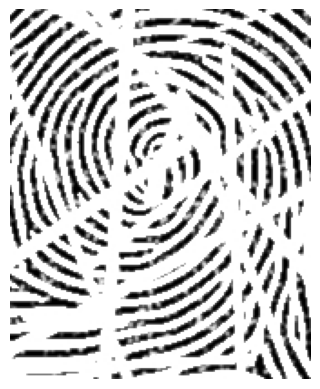

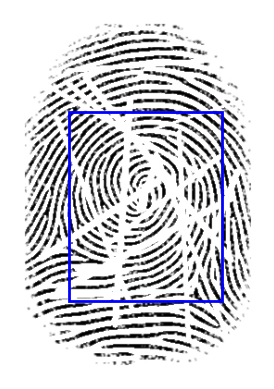

In [54]:
showROI(db_path=database,img_name='00074.jpg',yolo_model=model,agent=agent)